In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Leitura dos dados
dados = np.loadtxt("mnist_3000.txt")

# Separação dos dados
imagens = dados[:, 1:785]  # Cada linha corresponde aos pixels de uma pequena imagem 16x16
rotulos = dados[:, 0]   # Corresponde ao rótulo da imagem, no conjunto C = {0,1,2..., 9}

# Sorteio de índices aleatórios
i = np.random.permutation(imagens.shape[0])

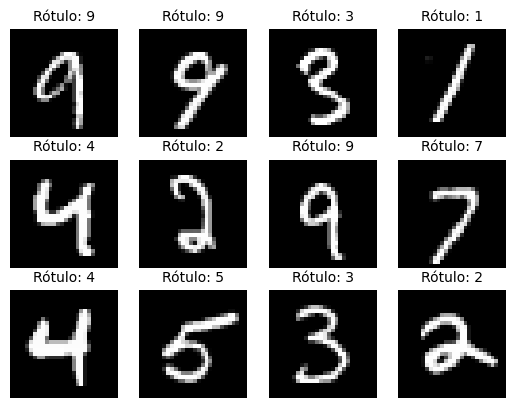

In [3]:
# Visualização de 12 imagens sorteadas aleatoriamente
for k in range(12):
    plt.subplot(3, 4, k + 1)  # Subplots são indexados a partir de 1
    plt.imshow(imagens[i[k]].reshape(28, 28), cmap="gray")  # Reshape para 16x16
    plt.axis('off')  # Remove os eixos
    rotulo = int(rotulos[i[k]])  # Obtém o rótulo como inteiro
    plt.title(f"Rótulo: {rotulo}", fontsize=10)

plt.show()

In [4]:
def zScore(data):
    """
    Normaliza os dados usando o método z-score.
    """
    return (data - np.mean(data, axis=0)) / (np.std(data, axis=0))

def minMaxNorm(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def train_split(dataset, labels, split):
    np.random.seed(42)
    indices = np.random.permutation(len(dataset))
    split_index = int(len(dataset) * split)

    train_indices = indices[:split_index]
    test_indices = indices[split_index:]

    train_set = dataset[train_indices]
    test_set = dataset[test_indices]

    train_labels = labels[train_indices]
    test_labels = labels[test_indices]

    return train_set, test_set, train_labels, test_labels
    

In [5]:
imagens = minMaxNorm(imagens)
train_set, test_set, train_labels, test_labels = train_split(imagens, rotulos, 0.7)

In [6]:
def logi(z):
    """Função logística."""
    return 1 / (1 + np.exp(-z))

def softmax(net):
    net = net.reshape(1, -1) 
    e_net = np.exp(net - np.max(net))
    return (e_net / np.sum(e_net, axis=1, keepdims=True)).flatten()

def MLP(x0):
    global w1, w2, w3, b1, b2, b3
    # Camada 1: 784 -> 120
    x1 = logi(x0 @ w1 + b1)

    # Camada 2: 120 -> 84
    x2 = logi(x1 @ w2 + b2)

    # Camada 3: 84 -> 10
    x3 = x2 @ w3 + b3 

    saida = softmax(x3)

    return x1, x2, x3, saida

def backprop(x0, x1, x2, x3, saida, gabarito, passo):
    global w1, w2, w3, b1, b2, b3

    e3 = saida - gabarito # Erro da camada de saída (softmax + entropia-cruzada)
        
    # Propagação do erro para a segunda camada oculta
    e2 = (e3 @ w3.T) * (1 - x2) * x2

    e1 = (e2 @ w2.T) * (1 - x1) * x1  # derivada da função logística 

    # Atualização dos pesos
    w3 -= passo * np.outer(x2, e3)
    b3 -= passo * e3

    w2 -= passo * np.outer(x1, e2)
    b2 -= passo * e2

    w1 -= passo * np.outer(x0, e1)
    b1 -= passo * e1



In [13]:
d0 = 784
d1 = 120
d2 = 84
d3 = 10

#  Vetores de peso
w1 = np.random.randn(784, 120) / np.sqrt(784)
w2 = np.random.randn(120, 84) / np.sqrt(120)
w3 = np.random.randn(84, 10) / np.sqrt(84)

# Vetores de Bias
b1 = np.random.randn(d1)  # Vetor de bias da camada oculta
b2 = np.random.randn(d2)  # Vetor de bias da camada de saída
b3 = np.random.randn(d3)

# Vetores de Erro
e0 = np.zeros(d0)
e1 = np.zeros(d1) 
e2 = np.zeros(d2) 
e3 = np.zeros(d3)

gabarito = np.zeros(d3)


In [14]:
epocas = 100
passo = 0.01
taxa_treino = []
taxa_teste = []

for epoca in range(epocas):
    # Embaralha os dados a cada época
    indices = np.random.permutation(len(train_set))
    train_set = train_set[indices]
    train_labels = train_labels[indices]
    acertos_treino = 0

    for i in range(len(train_set)):
        x0 = train_set[i]
        gabarito = np.zeros(10)
        gabarito[int(train_labels[i])] = 1

        x1, x2, x3, saida = MLP(x0)
        backprop(x0, x1, x2, x3, saida, gabarito, passo)

        if np.argmax(saida) == int(train_labels[i]):
            acertos_treino += 1

    taxa_treino.append(acertos_treino / len(train_set))

    # Avaliação
    acertos_teste = 0
    for i in range(len(test_set)):
        x0 = test_set[i]
        gabarito = np.zeros(10)
        gabarito[int(test_labels[i])] = 1

        _, _, _, saida = MLP(x0)

        if epoca == 0 and i < 3:
            print("Saída softmax:", saida)

        if np.argmax(saida) == int(test_labels[i]):
            acertos_teste += 1

    taxa_teste.append(acertos_teste / len(test_set))

    print(f"Época {epoca + 1}/{epocas} - Treino: {taxa_treino[-1]:.5f}, Teste: {taxa_teste[-1]:.5f}")


Saída softmax: [0.08372594 0.07626198 0.17205873 0.08287515 0.08038428 0.08838072
 0.133777   0.10480027 0.10495457 0.07278136]
Saída softmax: [0.08293163 0.0690065  0.17657402 0.07773982 0.07780243 0.08705292
 0.14283475 0.10717896 0.10522169 0.07365727]
Saída softmax: [0.08660713 0.06139662 0.18307973 0.07787759 0.07686091 0.08542299
 0.14858432 0.09766935 0.10697288 0.07552849]
Época 1/100 - Treino: 0.11714, Teste: 0.09778
Época 2/100 - Treino: 0.25000, Teste: 0.38000
Época 3/100 - Treino: 0.53000, Teste: 0.62778
Época 4/100 - Treino: 0.67810, Teste: 0.70444
Época 5/100 - Treino: 0.76571, Teste: 0.73778
Época 6/100 - Treino: 0.81190, Teste: 0.80778
Época 7/100 - Treino: 0.83714, Teste: 0.83222
Época 8/100 - Treino: 0.85571, Teste: 0.83000
Época 9/100 - Treino: 0.87238, Teste: 0.85000
Época 10/100 - Treino: 0.88762, Teste: 0.87000
Época 11/100 - Treino: 0.89429, Teste: 0.86556
Época 12/100 - Treino: 0.89857, Teste: 0.87111
Época 13/100 - Treino: 0.90810, Teste: 0.87556
Época 14/100 -

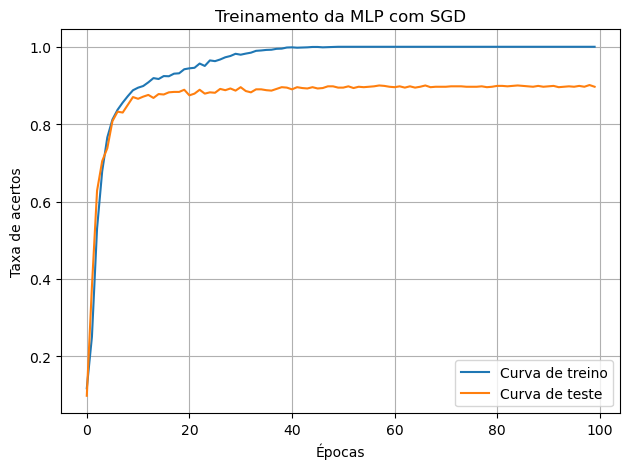

In [15]:
plt.plot(taxa_treino, label="Curva de treino")
plt.plot(taxa_teste, label="Curva de teste")
plt.xlabel("Épocas")
plt.ylabel("Taxa de acertos")
plt.title("Treinamento da MLP com SGD")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
